<div style="text-align: center; font-size: 40px; font-weight: bold;">IMAGE CAPTION GENERATOR</div>
<div style="height: 50px;"></div>

In [1]:
import numpy as np

In [1]:
# benötigte Bibliotheken importieren
import numpy as np
import pandas as pd
import os
#from glob import glob
import pickle
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing import image
from keras.utils import load_img, img_to_array, pad_sequences, to_categorical,plot_model
from keras.models import Model
from keras.layers import Input,Dense,LSTM,Embedding,Dropout,add
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam

from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from nltk.translate.bleu_score import sentence_bleu

# Einleitung

In diesem Projekt handelt es sich um Image Caption Generator, indem wir angesichts eines Bildes herausfinden können, worum es geht.

Der benutzte Datensatz ist Flickr8k, die über den Link https://www.kaggle.com/code/dbdmobile/image-captioner/input heruntergeladen werden kann. Ich mache mir das vortrainierte Modell VGG16 zunutze (VGG steht für Visual Geometry Group und ist eine Forschungsgruppe an der Universität Oxford).

![](VGG16.jpg)


# Datenverarbeitung

Die Bild- und Textdaten werden in den Ordnern `Images` bzw. `Captions` gespeichert

## Bilderdaten

In [2]:
# Pfad zu den Daten
data_path=os.path.join(os.getcwd(), 'Data')

# Pfad zu Arbeit Directory
working_dir = os.getcwd()

Wir werden das vortrainierte VGG16-Modell verwenden. Es ist erwähnenswert, dass es mit einer Dense Schicht endet, die für Klassifizierungsaufgaben verantwortlich ist. Zur Featuresextraktion werde ich also die letzte Schicht entfernen.

In [3]:
# laden das VGG16-Modell
model = VGG16()
# entfernen letzte Schicht
model = Model(inputs=model.inputs,outputs=model.layers[-2].output)

In [4]:
# Summary von Modell
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# Pfad zu Images
image_dir = os.path.join(data_path, 'Images')

Im nächsten Schritt werde ich die Bild-Features aus dem VGG-Modell extrahieren

In [6]:
# erzeugen ein Dictionary, um Features zu speichern
features = {}
# extrahieren Image Features
for img_name in tqdm(os.listdir(image_dir)): # tqdm für Visualisierung des Vorgangs
    img_path = image_dir + '/' + img_name
    # Die Standardeingabegröße für dieses Modell beträgt 224 x 224. Also müssen wir die Bilder umformen
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    # Image umformen, um das Modell zu passen.     
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocessing des Bildes für VGG
    image = preprocess_input(image)
    # extrahieren Features
    feature = model.predict(image, verbose=0)
    # image ID
    image_id = img_name.split('.')[0]
    # speichern Feature
    features[image_id] = feature

In [7]:
# speichern Image Features in pickle
pickle.dump(features, open(os.path.join(working_dir, 'features.pkl'), 'wb'))

In [8]:
# laden Features von pickle Datei
features_path = os.path.join(working_dir, 'features.pkl')
with open(features_path, 'rb') as file:
    features = pickle.load(file)

## Textdaten

In [9]:
# Die erste Zeile von captions.txt ist "image,caption". Deshalb überspringen wir diese Zeile
# lesen die Textdatei
with open(os.path.join(data_path, 'Captions\captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

Wenn wir uns `captions_doc` genauer ansehen, können wir sehen, dass es für jedes Bild entsprechende 5 Beschreibungen gibt, die so aussehen:

`1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .`

In [10]:
# Dictionary mit Keys=Image_id und Values=captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    # split durch Komma
    tokens = line.split(',')
    # entfernen alle Zeilen mit weniger als 2 Tokens, die möglicherweise nicht genügend Informationen haben 
    if len(tokens) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # Erweiterung aus Bild-ID entfernen
    image_id = image_id.split('.')[0]
    # 
    caption = " ".join(caption)
    # Liste von Captions erstellen
    if image_id not in mapping:
        mapping[image_id] = []
    # caption hinzufügen
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

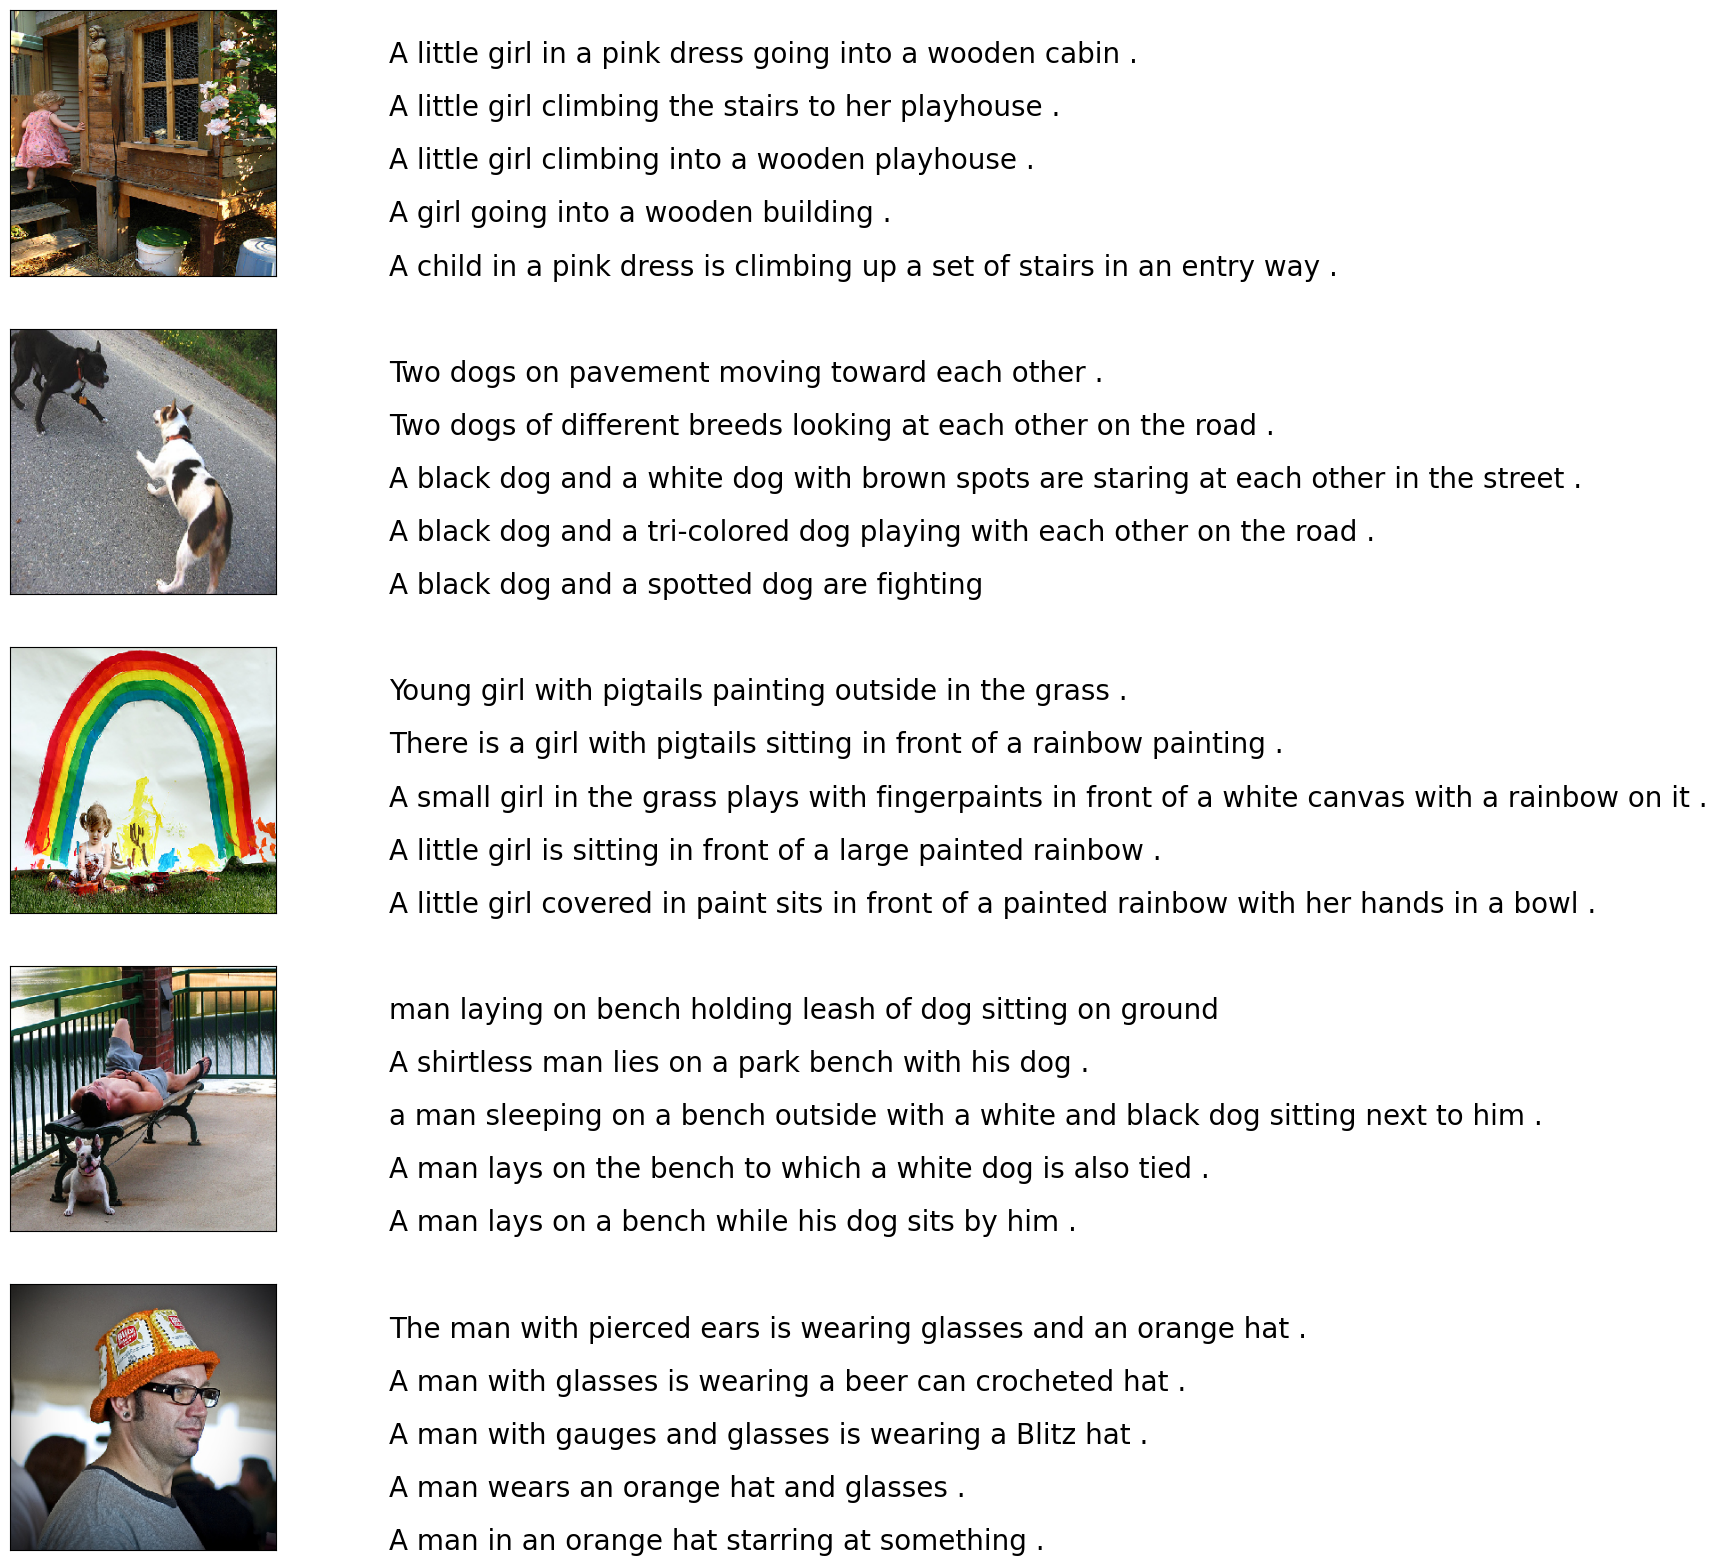

In [11]:
# 5 erste Beispiele
npic = 5
target_size = (299, 299)
path = os.path.join(data_path, 'Images/')
fig = plt.figure(figsize=(10,20))

count = 1
for img in os.listdir(path)[:npic]:
    
    filename = path + img
    captions = list(mapping[img.split(".")[0]])
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)
    count += 1
plt.show()

Anschließend bereinigen wir den Text auf folgende Weise, um die Größe des Vokabulars der Wörter zu reduzieren:

- wandeln alle Wörter in Kleinbuchstaben um.
- entfernen alle Satzzeichen.
- entfernen alle Wörter, die ein Zeichen oder weniger lang sind (z. B. „a“).
- entfernen alle Wörter mit Zahlen darin.

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # wandeln in Kleinbuchstaben um
            caption = caption.lower()
            # entfernen alle Satzzeichen
            caption = caption.replace('[^A-Za-z]', '')
            # löschen zusätzliche Leerzeichen
            caption = caption.replace('\s+', ' ')
            # fügen Start- und End-Tags hinzu
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
# ein Beispiel von Image_id
os.listdir(image_dir)[10]

'101654506_8eb26cfb60.jpg'

In [14]:
# vor Bereinigung
mapping['101654506_8eb26cfb60']

['A brown and white dog is running through the snow .',
 'A dog is running in the snow',
 'A dog running through snow .',
 'a white and brown dog is running through a snow covered field .',
 'The white and brown dog is running over the surface of the snow .']

In [15]:
# bereinigen den Text
clean(mapping)

In [16]:
# nach Bereinigung
mapping['101654506_8eb26cfb60']

['startseq brown and white dog is running through the snow endseq',
 'startseq dog is running in the snow endseq',
 'startseq dog running through snow endseq',
 'startseq white and brown dog is running through snow covered field endseq',
 'startseq the white and brown dog is running over the surface of the snow endseq']

In [17]:
# erstellen eine Liste von allen Captions
all_captions = [caption for captions in mapping.values() for caption in captions]

In [18]:
# prüfen
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [19]:
# Den Text tokenisieren
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [52]:
vocab_size

8485

In [20]:
len(tokenizer.word_index)

8484

In [21]:
tokenizer.word_index

{'startseq': 1,
 'endseq': 2,
 'in': 3,
 'the': 4,
 'on': 5,
 'is': 6,
 'and': 7,
 'dog': 8,
 'with': 9,
 'man': 10,
 'of': 11,
 'two': 12,
 'white': 13,
 'black': 14,
 'boy': 15,
 'are': 16,
 'woman': 17,
 'girl': 18,
 'to': 19,
 'wearing': 20,
 'at': 21,
 'people': 22,
 'water': 23,
 'red': 24,
 'young': 25,
 'brown': 26,
 'an': 27,
 'his': 28,
 'blue': 29,
 'dogs': 30,
 'running': 31,
 'through': 32,
 'playing': 33,
 'while': 34,
 'shirt': 35,
 'down': 36,
 'standing': 37,
 'ball': 38,
 'little': 39,
 'grass': 40,
 'snow': 41,
 'child': 42,
 'person': 43,
 'jumping': 44,
 'over': 45,
 'three': 46,
 'front': 47,
 'sitting': 48,
 'holding': 49,
 'up': 50,
 'field': 51,
 'small': 52,
 'by': 53,
 'a': 54,
 'large': 55,
 'green': 56,
 'one': 57,
 'group': 58,
 'yellow': 59,
 'her': 60,
 'walking': 61,
 'children': 62,
 'men': 63,
 'into': 64,
 'air': 65,
 'beach': 66,
 'near': 67,
 'mouth': 68,
 'jumps': 69,
 'another': 70,
 'for': 71,
 'street': 72,
 'runs': 73,
 'its': 74,
 'from': 75,

In [23]:
# holen die maximale Länge der verfügbaren Beschriftungen
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

# Modell

## Data Generator

In [24]:
# teilen Daten auf
image_ids=list(mapping.keys())
split=int(len(image_ids)* .90)
train=image_ids[:split]
test=image_ids[split:]

In [25]:
# erzeugen data generator
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Listen initialisieren, um Bilddaten, Textbilder und Vorhersagen zu speichern
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                # erstellen Sequenz
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    # spanten auf
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad Sequenzen
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Output-Sequenzen
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # Sequenzen in Liste hinzufügen
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

## Modell erstellen

In [26]:
# Image Schichten
image_input=Input(shape=(4096,))
drop1=Dropout(.1)(image_input)
encoder_ouputs=Dense(256,activation="relu")(drop1)

# Text Schichten
caption_input=Input(shape=(max_length,))
embed=Embedding(vocab_size,256,mask_zero=True)(caption_input)
drop2=Dropout(0.1)(embed)
decoder_ouputs=LSTM(256)(drop2)

# combinieren
add_layer=add([encoder_ouputs,decoder_ouputs])
dense_layer=Dense(256,activation="relu")(add_layer)
outputs=Dense(vocab_size,activation="softmax")(dense_layer)

model=Model(inputs=[image_input,caption_input],outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# trainieren das Modell
batch_size = 300
generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
steps = len(train) // batch_size
model.fit(generator, epochs=40, steps_per_epoch=steps, verbose=1)

Epoch 1/40


24/24 [==============================] - 314s 13s/step - loss: 6.3190 - accuracy: 0.0819
Epoch 2/40
24/24 [==============================] - 271s 11s/step - loss: 5.4829 - accuracy: 0.1235
Epoch 3/40
24/24 [==============================] - 279s 12s/step - loss: 5.0862 - accuracy: 0.1406
Epoch 4/40
24/24 [==============================] - 284s 12s/step - loss: 4.7960 - accuracy: 0.1541
Epoch 5/40
24/24 [==============================] - 282s 12s/step - loss: 4.4995 - accuracy: 0.1790
Epoch 6/40
24/24 [==============================] - 347s 15s/step - loss: 4.1663 - accuracy: 0.2144
Epoch 7/40
24/24 [==============================] - 364s 15s/step - loss: 3.8875 - accuracy: 0.2393
Epoch 8/40
24/24 [==============================] - 364s 15s/step - loss: 3.6875 - accuracy: 0.2589
Epoch 9/40
24/24 [==============================] - 380s 16s/step - loss: 3.5226 - accuracy: 0.2764
Epoch 10/40
24/24 [==============================] - 383s 16s/step - loss: 3.3860 - accuracy: 0.29

In [28]:
model.save("my_model.h5")

In [29]:
model = keras.models.load_model('my_model.h5')

## Caption generieren

In [30]:
# definieren ein Funktion, die integer in Wort umwandelt
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
# Caption generieren
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # nächstes WOrt vorhersagen
        yhat = model.predict([image, sequence], verbose=0)
        # Indizierung erwischen
        yhat = np.argmax(yhat)
        # Indiziereung zu WOrt umwandeln
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        # Eingabe für die Generierung des nächsten Wortes
        in_text += " " + word
        # stoppen wenn wir das End-Tag erreichen
        if word == 'endseq':
            break

    return in_text

In [33]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    # passen die Größe des Bildes an die VGG16-Eingabegröße an
    image = image.resize((224, 224))  
    image = np.array(image)
    image = preprocess_input(image)
    return image

def generate_caption_for_new_image(image_path):
    # verarbeiten das Bild vor
    new_image = preprocess_image(image_path)

    # generieren Features für das neue Bild mithilfe des vortrainierten VGG16-Modells
    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    new_image_features = vgg_model.predict(np.array([new_image]), verbose=0)

    # Caption für das neue Bild vorhersagen
    predicted_caption = predict_caption(model, new_image_features, tokenizer, max_length)  #loaded_model, new_image_features, loaded_tokenizer,

    # entfernen die Startseq- und Endeseq-Tokens
    predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()

    # schreiben den ersten Buchstaben groß
    predicted_caption = predicted_caption.capitalize()

    # fügen einen Punkt hinzu
    if not predicted_caption.endswith('.'):
        predicted_caption += '.'

    # zeigen das Bild und die vorhergesagte Bildunterschrift an
    plt.imshow(Image.open(image_path))
    plt.title(predicted_caption)
    plt.axis('off')
    plt.show()


# Vorhersage und Bewertung

## Vorhersage

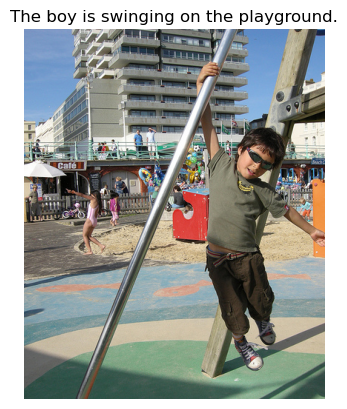

In [34]:
new_image_path = os.path.join(os.getcwd(), 'Data/Images/3759492488_592cd78ed1.jpg')
generate_caption_for_new_image(new_image_path)

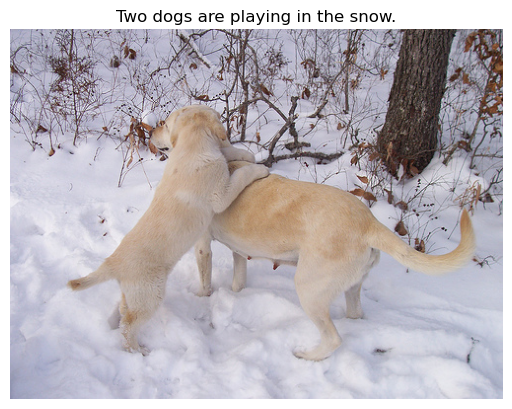

In [98]:
new_image_path = os.path.join(os.getcwd(), 'Data/Images/133905560_9d012b47f3.jpg')
generate_caption_for_new_image(new_image_path)

## Bewertung

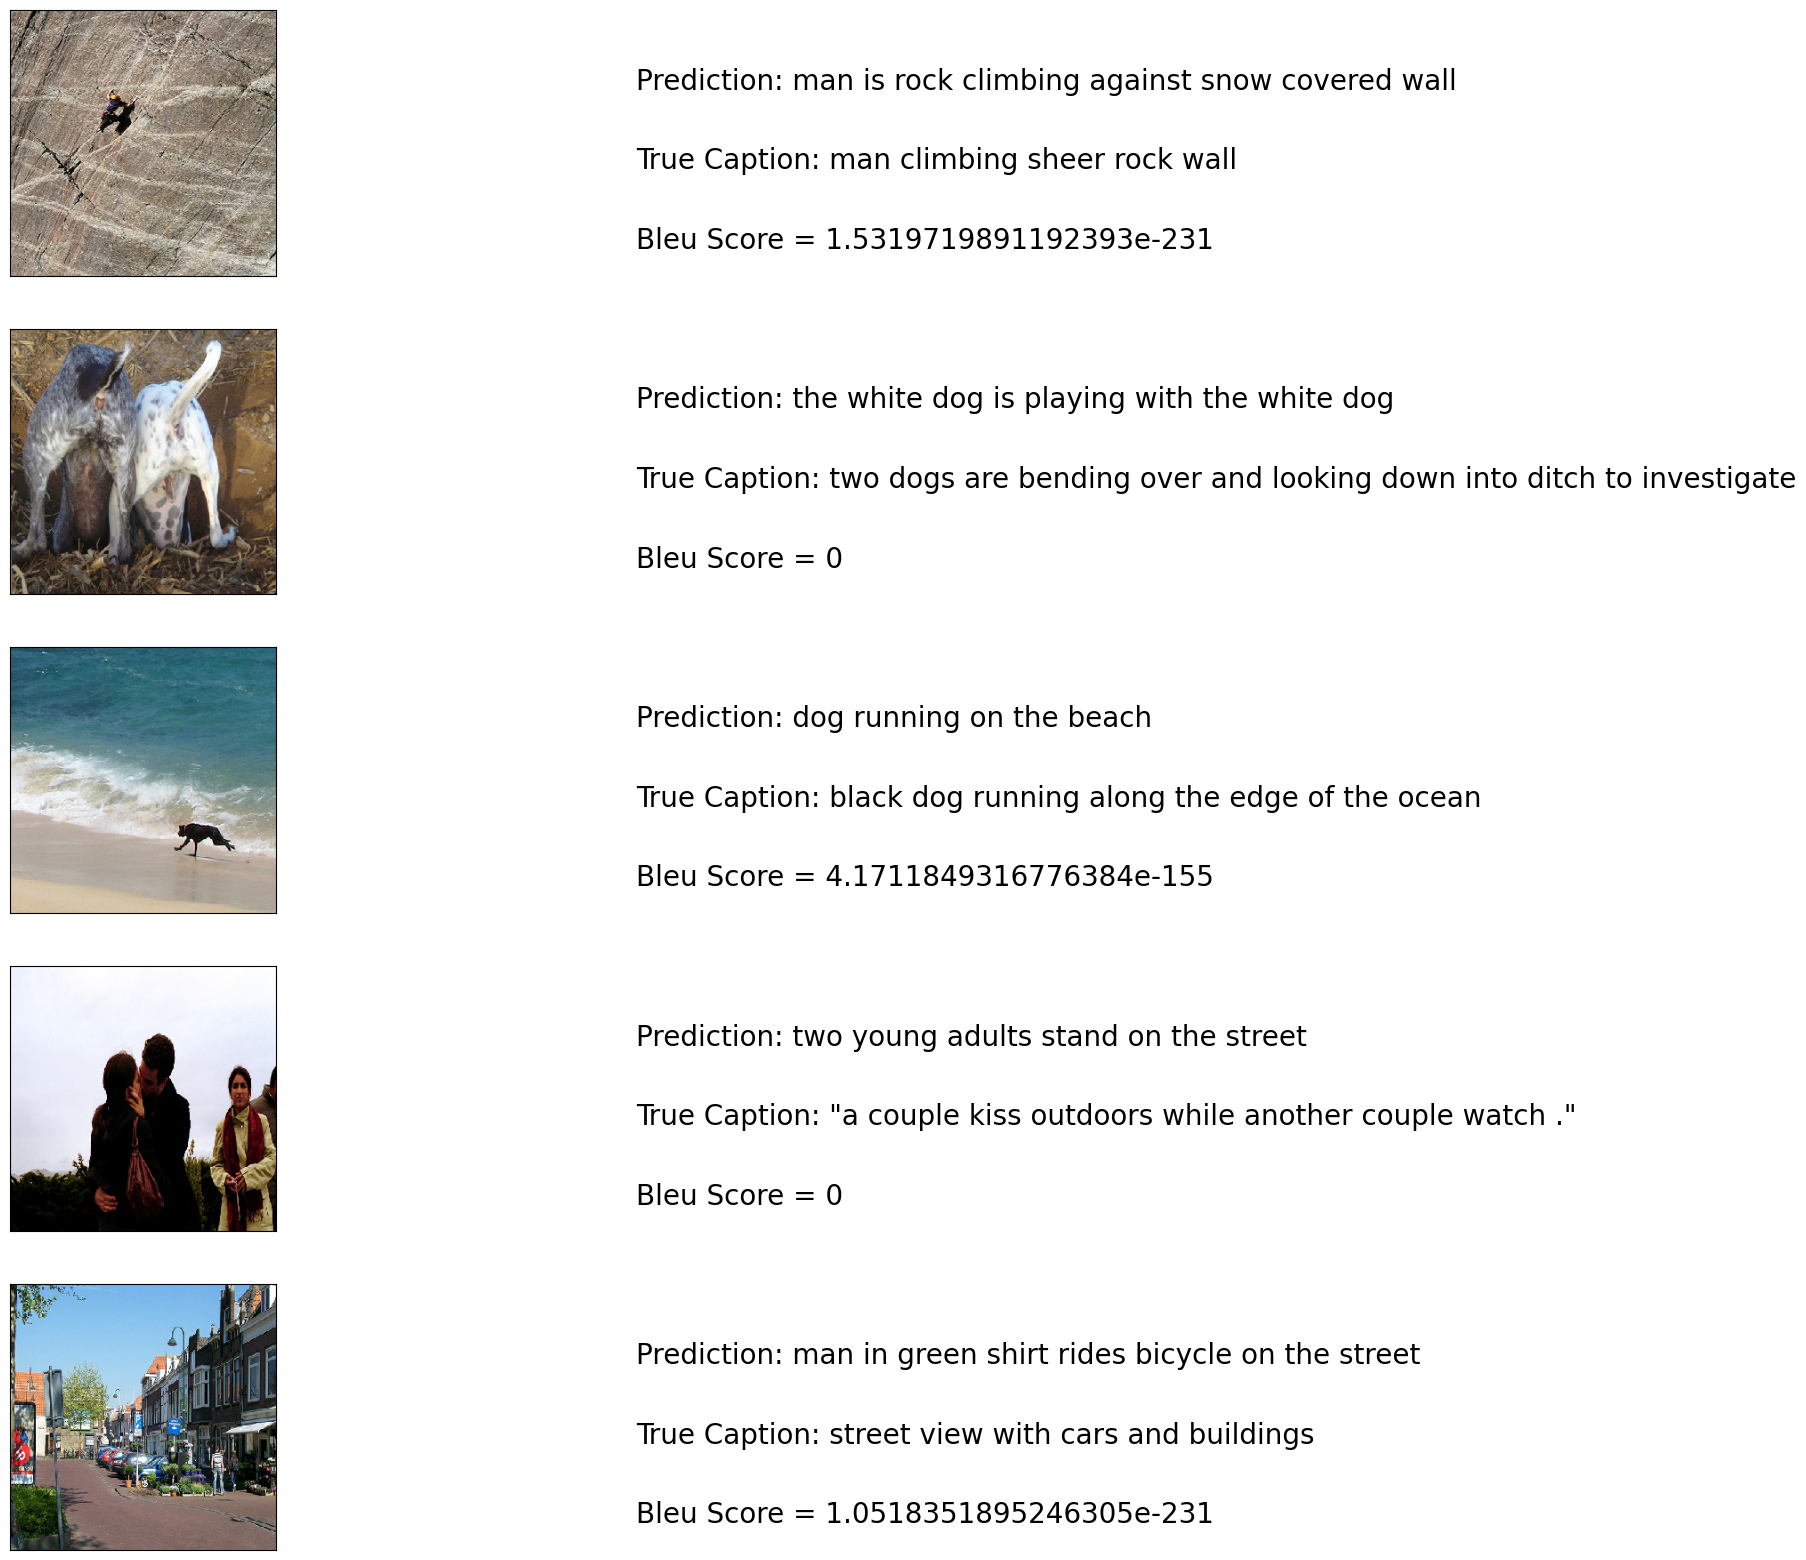

In [100]:
# 5 Test-Beispiele mit True_Caption und Bleu-Score

npic = 5
target_size = (299, 299)
path = os.path.join(data_path, 'Images/')
fig = plt.figure(figsize=(20,20))

count = 1
for img in os.listdir(path)[split:][101: npic+101]:
    
    filename = path + img
    caption=list(mapping[img.split(".")[0]])[0]
    true_caption = ' '.join(caption.split()[1: -1])
    
    new_image = preprocess_image(filename)

    # generieren features für neues Bild
    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    new_image_features = vgg_model.predict(np.array([new_image]), verbose=0)

    # sagen caption für neues Bild vorher
    predicted_caption = predict_caption(model, new_image_features, tokenizer, max_length)  #loaded_model, new_image_features, loaded_tokenizer,

    # entfernen startseq und endseq tokens
    predicted_caption = predicted_caption.replace('startseq', '').replace('endseq', '').strip()
    
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.text(0,0.7,'Prediction: '+predicted_caption, fontsize=20)
    ax.text(0,0.4, 'True Caption: '+ true_caption, fontsize=20)
    ax.text(0, 0.1, 'Bleu Score = {}'.format(sentence_bleu([true_caption.split()], predicted_caption.split())), fontsize = 20)
    count += 1
plt.show()

Jedoch bekommen wir komische Beschreibungen...

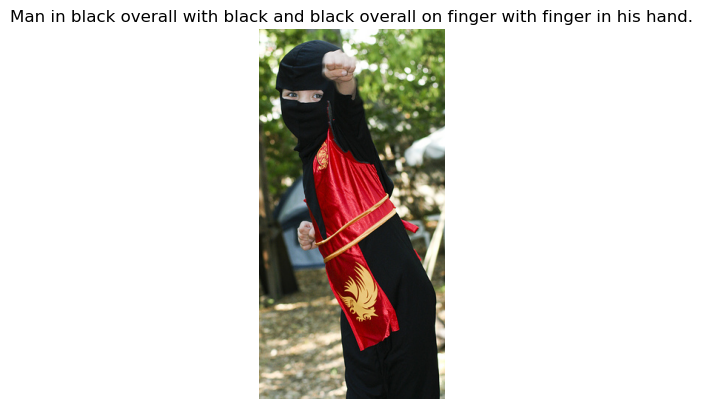

In [35]:
new_image_path = os.path.join(os.getcwd(), 'Data/Images/1420060020_7a6984e2ea.jpg')
generate_caption_for_new_image(new_image_path)

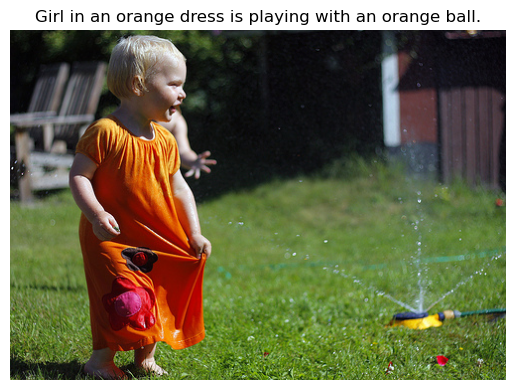

In [45]:
new_image_path = os.path.join(os.getcwd(), 'Data/Images/3767841911_6678052eb6.jpg')
generate_caption_for_new_image(new_image_path)

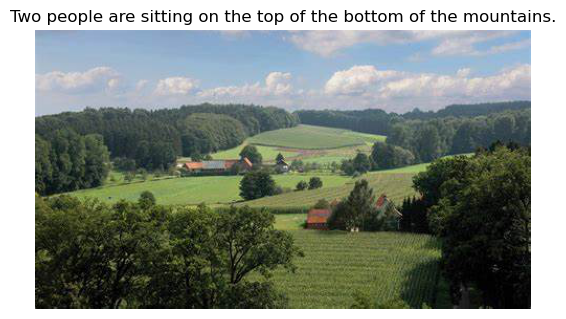

In [41]:
new_image_path = os.path.join(os.getcwd(), 'Data/test2.jpg')
generate_caption_for_new_image(new_image_path)

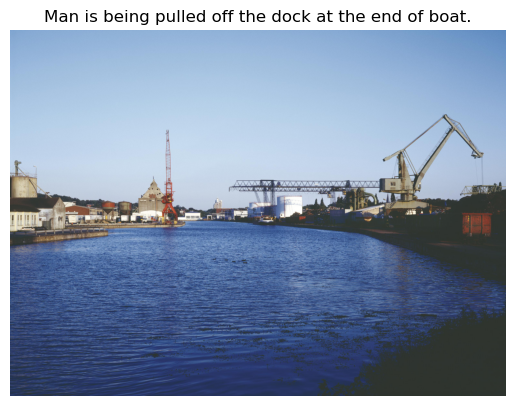

In [42]:
new_image_path = os.path.join(os.getcwd(), 'Data/Baeder-Freizeit-Freizeit-Stadtrundfahrten-Fahrt-Hafen-2020-Rechte-ok-1.jpg')
generate_caption_for_new_image(new_image_path)